# User-Defined Functions (UDF) in openEO

While openEO supports a wide range of pre-defined processes and allows to build more complex user-defined processes from them, you sometimes need operations or algorithms that are not (yet) available or standardized as openEO process. User-Defined Functions (UDF) is an openEO feature (through the run_udf process) that aims to fill that gap by allowing a user to express (a part of) an algorithm as a Python/R/… script to be run back-end side.

Though several types of algorithms can be used as UDF applications, in this notebook, we showcase a simple example of how to work with UDF using the openEO Python Client library.

In [1]:
# estabish connection to the backend and authenticate it
import openeo

connection = openeo.connect(url="openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [2]:
# load collection

cube = connection.load_collection(
    "SENTINEL2_L2A",
    bands=["B04", "B03", "B02"],
    temporal_extent=("2022-05-01", "2022-05-30"),
    spatial_extent={
        "west": 5.05,
        "south": 51.21,
        "east": 5.1,
        "north": 51.23,
        "crs": "EPSG:4326",
    },
    max_cloud_cover=50,
)

cube = cube.reduce_dimension(dimension="t", reducer="max")
cube

Here the UDF code shown in the following cell does the actual value rescaling. 

In [3]:
# Build a UDF object from an inline string with Python source code.
udf = openeo.UDF(
    """
from openeo.udf import XarrayDataCube

def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    array = cube.get_array()
    array.values = 0.0001 * array.values
    return cube
"""
)

User can also load their UDF from a seperate file using `openeo.UDF.from_file('my_udf.py')` and apply it. 

In [4]:
# Apply the UDF to a cube.
rescaled_cube = cube.apply(process=udf)

In [5]:
rescaled_cube.download("rescale_s2.tiff")

### Visualize the result

In [8]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

img = rasterio.open("rescale_s2.tiff").read()


def normalizeimg(data):
    data = data.astype(float)
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i], in_range=(p2, p98))
    return data

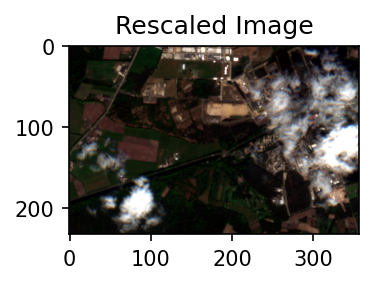

In [9]:
fig, ax = plt.subplots(figsize=(6, 2), dpi=150)
ax.imshow(normalizeimg(np.moveaxis(img, 0, -1)))

ax.set_title("Rescaled Image")

# Adjusting the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()